In [17]:
# generic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# project specific custom libraries
from config import *
from simulation import simulate_decay_times
from analysis import *

from joblib import delayed, Parallel

In [18]:
#set a seed for numpys random number generator
np.random.seed(42)

In [19]:
t_bounds = [0, 20000e-9]
n = 10000
n_sims = 1000

MUON_estimate = 2e-6
PION_estimate = 1.2e-8
initial_guess = [MUON_estimate, PION_estimate]

In [20]:
def simulation(n, t_bounds, initial_guess, bins=150):

    simulated_decay_points = simulate_decay_times(n, t_bounds[1])
    counts, bins = np.histogram(simulated_decay_points[:, 0] , bins=150, density=False)

    return binned_maximum_likelihood_fit_2(counts, bins, initial_guess)

In [21]:
# simulation_results = [simulation(n, t_bounds, initial_guess) for _ in range(n_sims)]
simulation_results = Parallel(n_jobs=-1)(delayed(simulation)(n, t_bounds, initial_guess) for _ in range(n_sims))

/Users/lucien/Documents/Lucien/002-Bildung/2023-00-00-Universität/Semester 4 FS2024/PHY 241 Data Analysis II/Project/Code/config.py:13: RuntimeWarning: overflow encountered in exp
  second_part = exp(- t / muon_mean_lifetime) - exp(- t / pion_mean_lifetime)
/Users/lucien/Documents/Lucien/002-Bildung/2023-00-00-Universität/Semester 4 FS2024/PHY 241 Data Analysis II/Project/Code/analysis.py:218: RuntimeWarning: invalid value encountered in log
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/lucien/Documents/Lucien/002-Bildung/2023-00-00-Universität/Semester 4 FS2024/PHY 241 Data Analysis II/Project/Code/analysis.py:218: RuntimeWarning: divide by zero encountered in log
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/lucien/Documents/Lucien/002-Bildung/2023-00-00-Universität/Semester 4 FS2024/PHY 241 Data Analysis II/Project/Code/analysis.py:218: RuntimeWarning: invalid value encountered in multiply
  nll = - np.sum(counts * np.log(estimated_counts))
/Users/lucie

In [22]:
simulation_results = pd.DataFrame(np.array(simulation_results), columns=['MUON_estimate', 'PION_estimate', 'MUON_uncer', 'PION_uncer'])
simulation_results.replace([np.inf, -np.inf], np.nan, inplace=True)
simulation_results.dropna(inplace=True)
simulation_results = simulation_results[simulation_results['MUON_estimate']>0]
simulation_results = simulation_results[simulation_results['PION_estimate']>0]
simulation_results = simulation_results[simulation_results['MUON_estimate']>simulation_results['PION_estimate']]

In [23]:
simulation_results

,MUON_estimate,PION_estimate,MUON_uncer,PION_uncer
0,0.000002,3.144494e-08,1.425632e-08,3.469601e-09
1,0.000002,2.413073e-08,1.523856e-08,2.002867e-09
2,0.000002,2.728890e-08,1.496899e-08,2.186815e-09
3,0.000002,3.145878e-08,1.424151e-08,3.398550e-09
4,0.000002,2.565447e-08,1.453861e-08,2.592702e-09
...,...,...,...,...
995,0.000002,2.841483e-08,1.435596e-08,2.536170e-09
996,0.000002,2.501526e-08,1.491366e-08,2.242965e-09
997,0.000002,2.547164e-08,1.574567e-08,2.375813e-09
998,0.000002,2.482783e-08,1.459672e-08,2.220661e-09


In [24]:
MUON_mean = simulation_results['MUON_estimate'].mean()
PION_mean = simulation_results['PION_estimate'].mean()
MUON_uncer = np.sqrt(np.mean(np.power(simulation_results['MUON_uncer'],2)))
PION_uncer = np.sqrt(np.mean(np.power(simulation_results['PION_uncer'],2)))
MUON_std = simulation_results['MUON_estimate'].std()
PION_std = simulation_results['PION_estimate'].std()

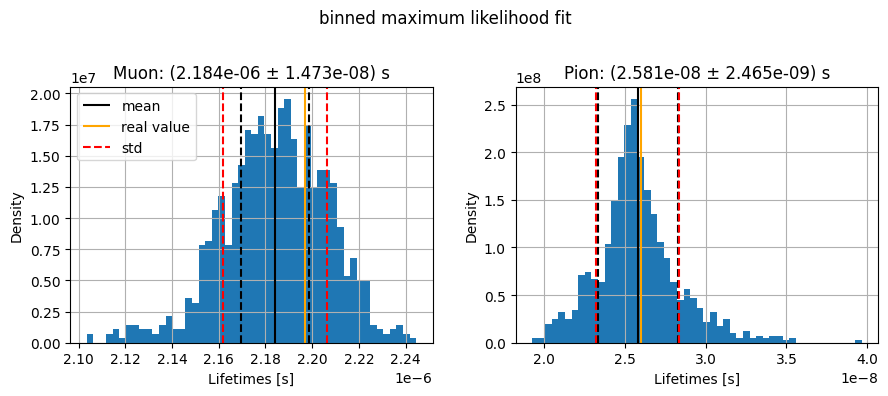

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
simulation_results.hist(column=['MUON_estimate'], ax=ax[0], bins=50, density=True)
simulation_results.hist(column=['PION_estimate'], ax=ax[1], bins=50, density=True)
for i in ax:
    i.set_ylabel('Density')
    i.set_xlabel('Lifetimes [s]')
    i.set_ylim(i.get_ylim())

ax[0].vlines(MUON_mean, *ax[0].get_ylim(), color='k', label='mean')
ax[1].vlines(PION_mean, *ax[1].get_ylim(), color='k')

ax[0].vlines(MUON_MEAN_LIFETIME, *ax[0].get_ylim(), color='orange', label='real value')
ax[1].vlines(PION_MEAN_LIFETIME, *ax[1].get_ylim(), color='orange')

ax[0].vlines([MUON_mean + MUON_uncer, MUON_mean - MUON_uncer], *ax[0].get_ylim(), color='k', linestyle='--')
ax[1].vlines([PION_mean + PION_uncer, PION_mean - PION_uncer], *ax[1].get_ylim(), color='k', linestyle='--')

ax[0].vlines([MUON_mean + MUON_std, MUON_mean - MUON_std], *ax[0].get_ylim(), color='r', linestyle='--', label='std')
ax[1].vlines([PION_mean + PION_std, PION_mean - PION_std], *ax[1].get_ylim(), color='r', linestyle='--')


ax[0].title.set_text(f'Muon: ({MUON_mean:.3e} ± {MUON_uncer:.3e}) s')
ax[1].title.set_text(f'Pion: ({PION_mean:.3e} ± {PION_uncer:.3e}) s')

fig.suptitle('binned maximum likelihood fit')
ax[0].legend()
plt.tight_layout()
plt.savefig('../Documentation/images/estimators_hist_likelihood.pdf')

In [26]:
MUON_pull = pull(MUON_MEAN_LIFETIME, simulation_results['MUON_estimate'], MUON_uncer)
PION_pull = pull(PION_MEAN_LIFETIME, simulation_results['PION_estimate'], PION_uncer)

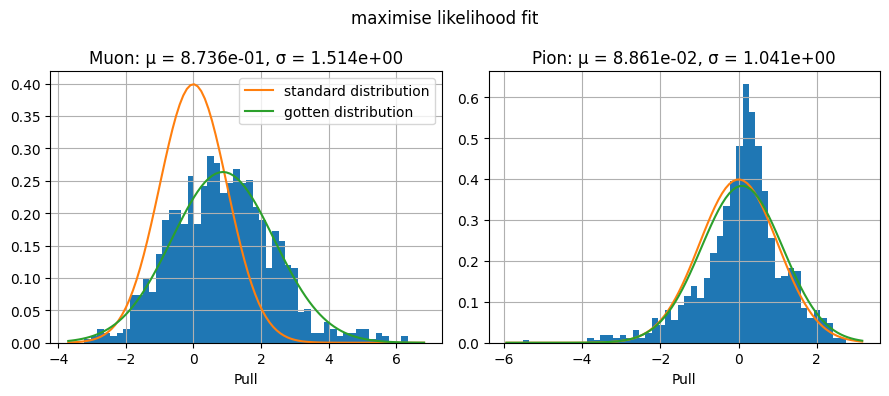

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
ax[0].hist(MUON_pull, bins=50, density=True)
ax[1].hist(PION_pull, bins=50, density=True)

ts_muon = np.linspace(*ax[0].get_xlim(),100)
ax[0].plot(ts_muon, norm.pdf(ts_muon), label='standard distribution')
ax[0].plot(ts_muon, norm.pdf(ts_muon, np.mean(MUON_pull), np.std(MUON_pull)), label='gotten distribution')

ts_pion = np.linspace(*ax[1].get_xlim(),100)
ax[1].plot(ts_pion, norm.pdf(ts_pion))
ax[1].plot(ts_pion, norm.pdf(ts_pion, np.mean(PION_pull), np.std(PION_pull)))

ax[0].set_title(f'Muon: µ = {np.mean(MUON_pull):.3e}, σ = {np.std(MUON_pull):.3e}')
ax[1].set_title(f'Pion: µ = {np.mean(PION_pull):.3e}, σ = {np.std(PION_pull):.3e}')

for i in ax:
    # i.set_ylabel('De')
    i.set_xlabel('Pull')
    i.grid()

ax[0].legend()
fig.suptitle('maximise likelihood fit')
plt.tight_layout()
plt.savefig('../Documentation/images/estimators_pull_likelihood.pdf')